In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

## 缺失值处理

通过建立新的dataframe来使得缺失值分析更为简便

In [17]:
data = pd.read_csv('数据集/train_data.csv')

In [18]:
def missingValue(df):
    result = pd.DataFrame(df.isnull().sum(),columns = ['missing value'])
    result['exist value'] = len(df) - result['missing value'] 
    result['total'] = len(df)
    result['dtype'] = df.dtypes
    result['ratio %'] = result['missing value'] / result['total'] * 100
    result = result[result['missing value'] != 0]
    
    return result

print('uv == 0 的数目: ')
print(data[data['uv'] == 0]['uv'].sum())
print('pv == 0 的数目: ')
print(data[data['pv'] == 0]['pv'].sum())
missingValue(data)

uv == 0 的数目: 
0.0
pv == 0 的数目: 
0.0


,missing value,exist value,total,dtype,ratio %
pv,18,41422,41440,float64,0.043436
uv,18,41422,41440,float64,0.043436


此外还存在少量缺失值’--‘在rentType中,因为数目少，所以当做缺失值。'暂无数据' 在houseToward中和因为其存在的数目较多，暂且当做一个新的类别。对于‘暂无信息’，暂且新先当缺失值处理

In [19]:
print(data['rentType'].value_counts())
print(data['houseToward'].value_counts())
print(data['buildYear'].value_counts())

未知方式    30759
整租       5472
合租       5204
--          5
Name: rentType, dtype: int64
南       34377
南北       2254
北        2043
暂无数据      963
东南        655
东         552
西         264
西南        250
西北         58
东西         24
Name: houseToward, dtype: int64
1994    2851
暂无信息    2808
2006    2007
2007    1851
2008    1849
        ... 
1939       2
1926       2
1951       1
1962       1
1950       1
Name: buildYear, Length: 80, dtype: int64


### 初步处理
对于缺失值的判断和处理，这里只是一个初步处理，具体修正还得看model训练出来的效果。  
这里先用：  
'未知方式'代替'--' in rentType  
'pv'和'uv' 用均值代替  
'buildYear' 也用总数代替  
'暂无数据' in houseToward 先暂且当做一个新的类别  
  
此外，需要对'buildYear'转化为int  
清除city  
清除ID  
将tradeTime分为出年和月  

In [20]:
# 清除city  ID
ID = data.loc[:,'ID']
CITY = data.loc[:,'city']
data = data.drop(['ID','city'],axis=1)


In [21]:
from sklearn.preprocessing import LabelEncoder


# rentTpye 更新'未知方式'为'--'
data['rentType'][data['rentType'] == '--'] = '未知方式'

# 提取object数据和numericla数据
categories = [f for f in data.columns if data.dtypes[f] == object ]
numerical = [f for f in data.columns if data.dtypes[f] != object ]

# 把buildYear 和 tradeTime 拉出来
numerical.append(categories.pop())
numerical.append(categories.pop())

# 用labelencoder 转换object数据
for x in categories:
    data[x] = LabelEncoder().fit_transform(data[x])
    

In [22]:
# 将buildYear转换为int
buildYearMode = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
data['buildYear'][data['buildYear'] == '暂无信息'] = buildYearMode.iloc[0][0]
data['buildYear'] = data['buildYear'].astype(int)

# 处理pv和uv
data['pv'].fillna(value=data['pv'].mean(),inplace=True)
data['uv'].fillna(value=data['uv'].mean(),inplace=True)
data['pv'] = data['pv'].astype(int)
data['uv'] = data['uv'].astype(int)

In [23]:
# 分隔tradeTime
def myTime(x):
    x = x.split('/')
    m = x[1]
    y = x[0]
    if len(m) == 1:
        m = '0' + m
    return (y+m)
data['tradeTime'] = data['tradeTime'].apply(lambda x: myTime(x))

## 异常值处理   

用到孤立森林

针对area和totalFloor的异常处理，是根据主观+可视化得到的结果(可画散点图支撑)

In [24]:
from sklearn.ensemble import IsolationForest

In [25]:
# 处理tradeMoney
IForest = IsolationForest(contamination=0.01)
IForest.fit(data['tradeMoney'].values.reshape(-1,1))
y_pred = IForest.predict(data['tradeMoney'].values.reshape(-1,1)) # -1 为异常点 1位正常点
# a = pd.DataFrame(y_pred)
# a[0].value_counts()
data = data.drop(data.loc[y_pred == -1].index)

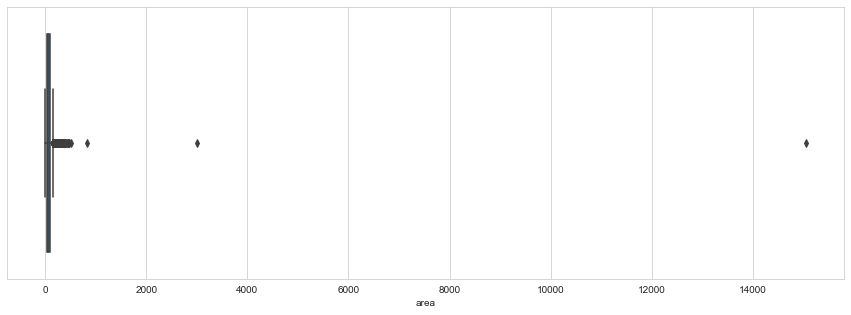

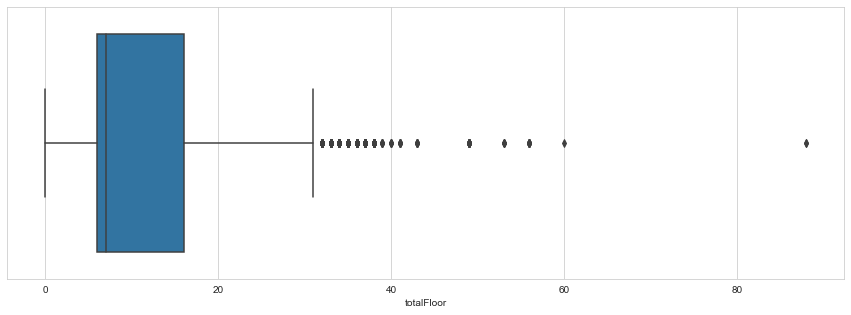

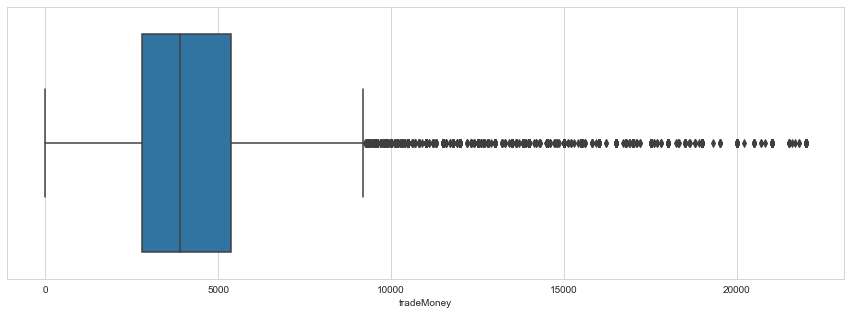

In [26]:
# 处理totalFloor 和area
# 此处先进行处理
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.boxplot(data['area'])
plt.figure(figsize=(15,5))
sns.boxplot(data['totalFloor'])
plt.figure(figsize=(15,5))
sns.boxplot(data['tradeMoney'])



In [27]:
# 主观判断 area 异常点在800左右,选择低于400的
df = data[ data['area']<400]
# tradeMoney 先暂且不drop
# totalFloor 80多层也不奇怪在上海
data = df.drop(df[df['totalFloor'] == 0].index)


## 深度清洗

主要思路分析
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。 采用主观+数据可视化的方式。

In [37]:
region_index = data['region'].value_counts().index
region_index =  region_index.sort_values()

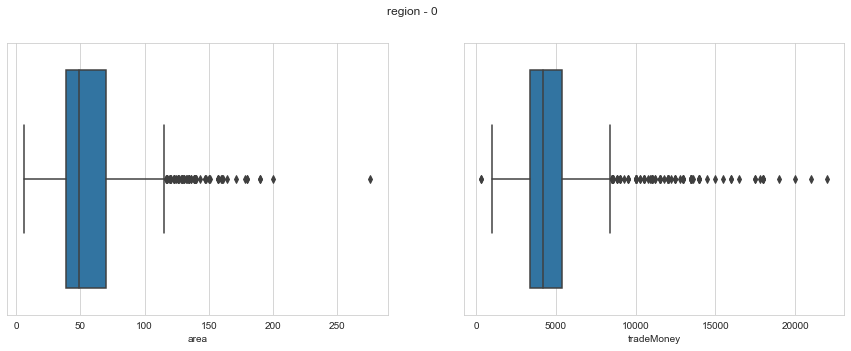

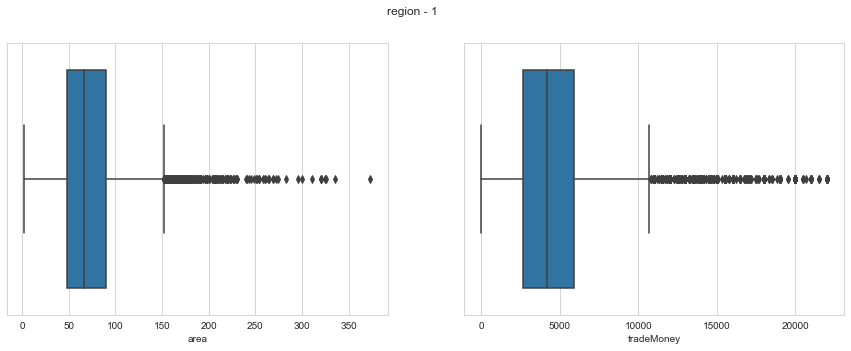

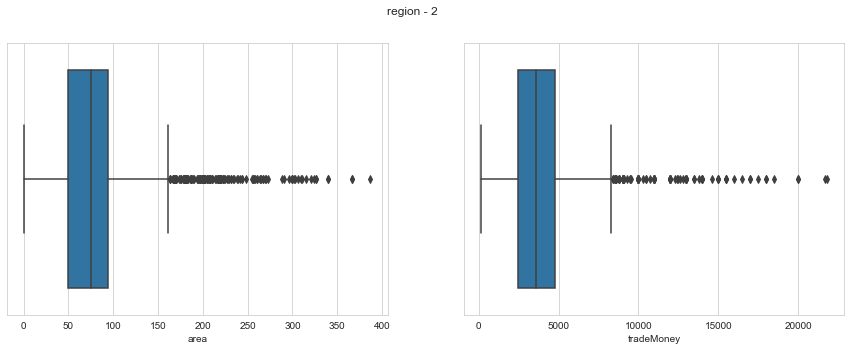

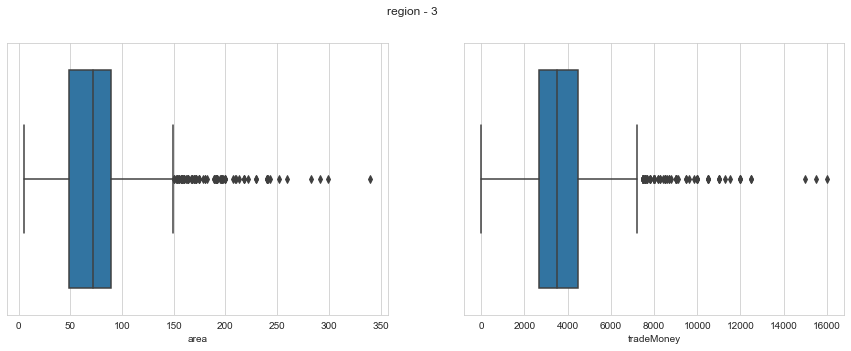

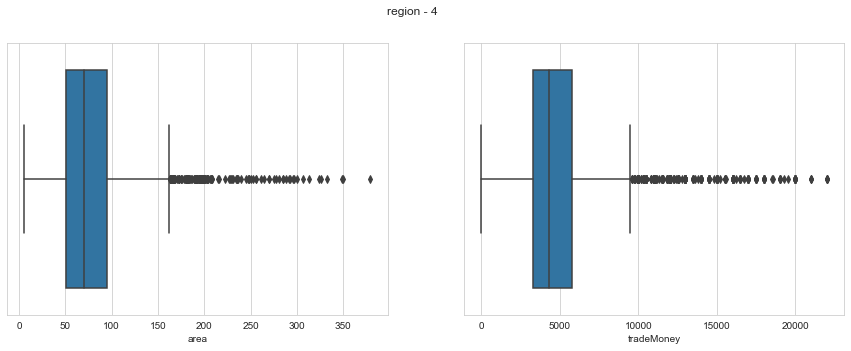

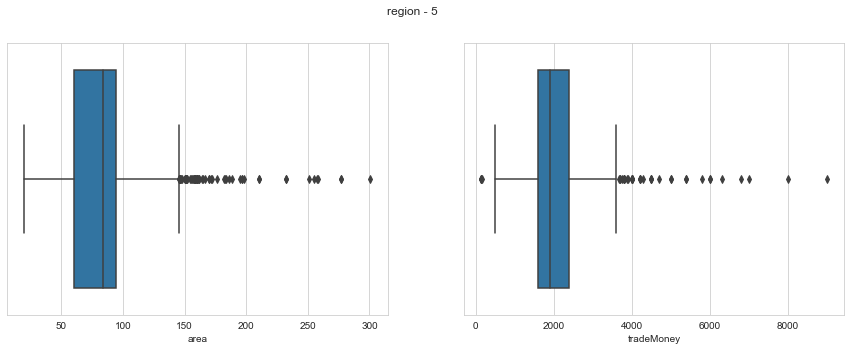

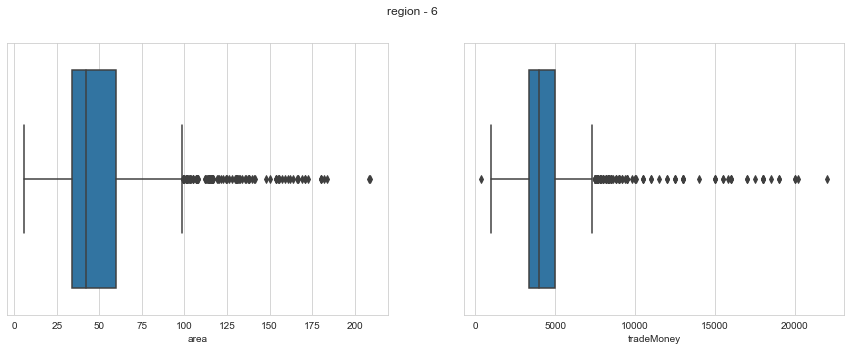

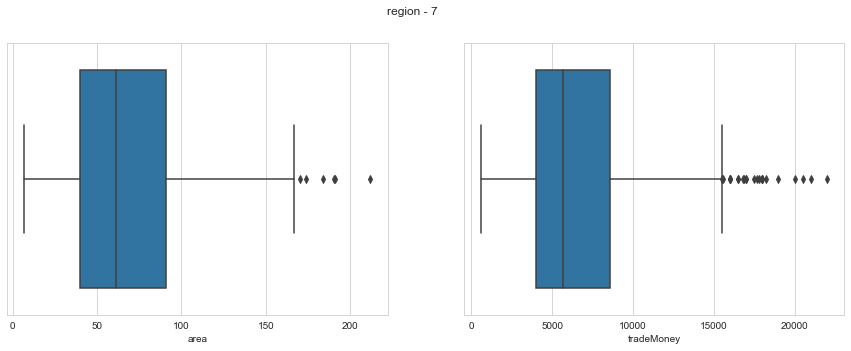

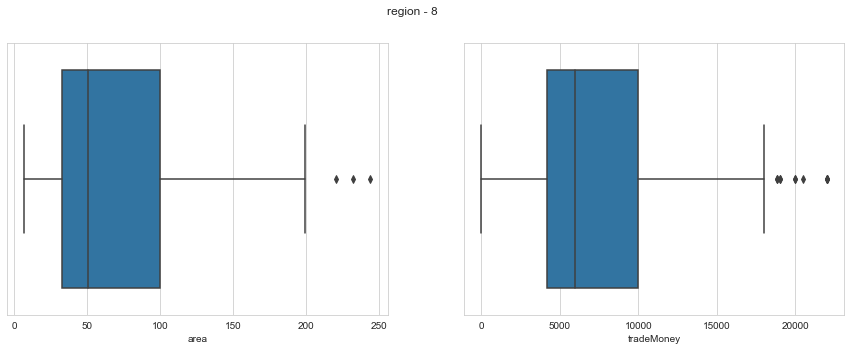

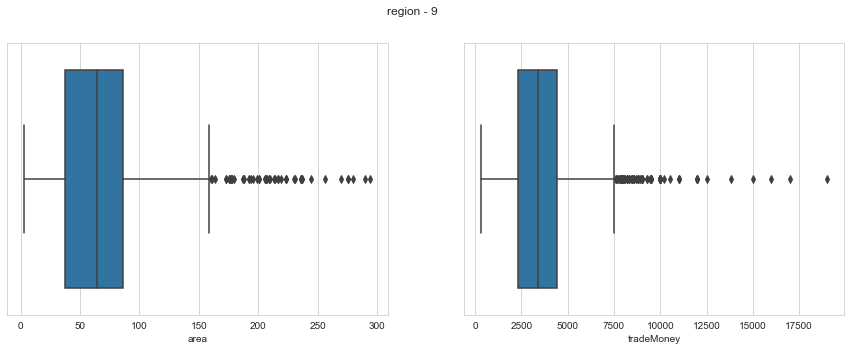

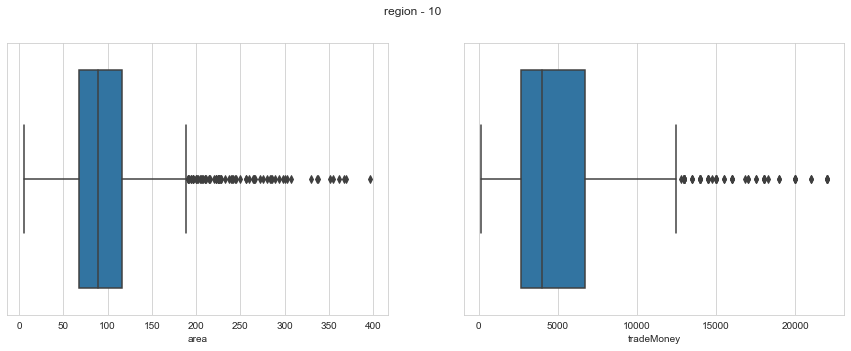

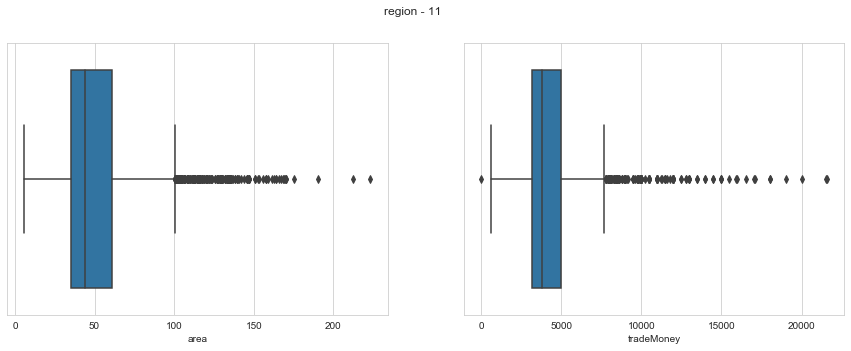

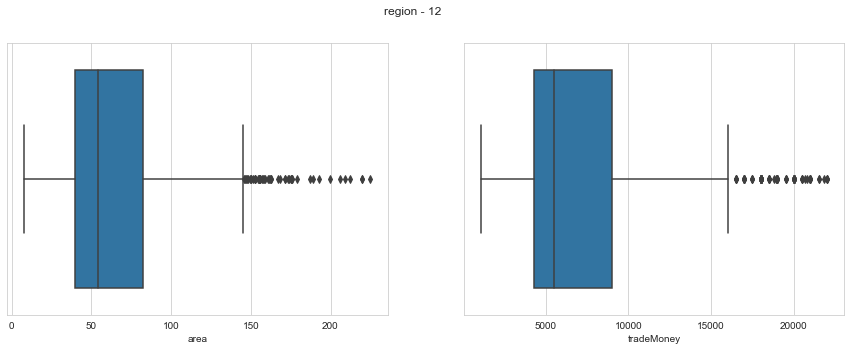

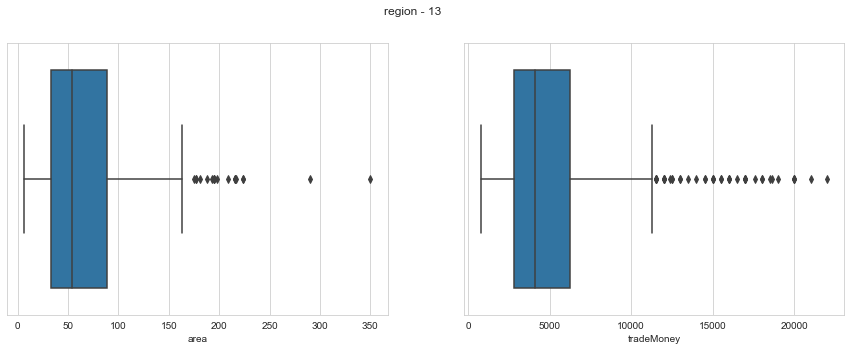

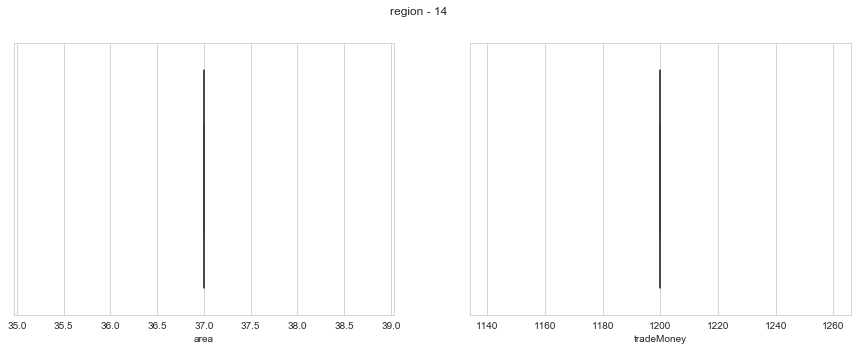

In [38]:
for x in region_index:
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.boxplot(data[data['region'] == x]['area'])
    plt.subplot(1,2,2)
    sns.boxplot(data[data['region'] == x]['tradeMoney'])
    plt.suptitle('region - {}'.format(x))
    plt.show()

In [29]:
data['region'].value_counts().index

Int64Index([1, 4, 2, 9, 11, 3, 5, 6, 7, 12, 0, 13, 10, 8, 14], dtype='int64')